# Question6_Regression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
import sklearn as sk
import numpy as np

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Define the path to your data
data_path = "/content/drive/MyDrive/SEMG_DB1"

## reading and preprocessing the data:
there is two function which were used to skip throgh all text files in the two folders, read their data, extract them as dataframe, delete the NaN values and delete the last column in some files that is a wrong and noisy data. they also extract the labels (based on thelast column) for each line of data. so there is some differences from the classification part.

In [ ]:
def process_files(folder_path):
    data = []
    labels = []

    # Loop through each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            # Read the text file using pandas
            df = pd.read_csv(file_path, sep='\s+', header=None, skiprows=8, engine='python')

            # Drop the last column if it exists
            if len(df.columns) > 5:  # Assuming the last column is the one you want to drop
                df = df.iloc[:, :-1]

            # Drop NaN values
            df.dropna(inplace=True)

            # Extract labels from the last column
            labels.append(df.iloc[:, -1].values)

            # Drop the last column to use the remaining columns as inputs
            df.drop(df.columns[-1], axis=1, inplace=True)

            # Convert dataframe to numpy array
            file_data = df.values
            # Append data to the list
            data.extend(file_data)

    return data, labels



In [ ]:
def load_data(data_path):
    all_data = []
    all_labels = []

    # Loop through each folder in the data path
    for folder_name in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder_name)
        if os.path.isdir(folder_path):
            # Process files in the folder
            data, labels = process_files(folder_path)
            all_data.extend(data)
            all_labels.extend(labels)
        print(len(data))

    # Convert labels to numpy arrays
    all_labels = np.concatenate(all_labels)

    return np.array(all_data), all_labels

there is also a new function for windowing part.

In [ ]:
# Perform windowing
def create_windows(data, labels, window_size):
    X_windows = []
    y_windows = []

    for i in range(len(data) - window_size):
        window_data = data[i:i+window_size]
        window_label = labels[i+window_size]

        X_windows.append(window_data)
        y_windows.append(window_label)

    return np.array(X_windows), np.array(y_windows)

the functions' outputs are in the form if numpy arrays. I print their shape to see if the reading and extracting process were done completely. I printed the number of data sample for each folder as well.

In [ ]:
# Load data
X, y = load_data(data_path)

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

850491
474497
X shape: (1324988, 4)
y shape: (1324988,)


I also Print two lines of them to see their format.

In [ ]:
print(X[0:2])
print(y[0:2])

[[-0.0015 -0.0068  0.003  -0.0091]
 [-0.0053 -0.0458 -0.0008 -0.0098]]
[-4.5 -4.6]


this part do the windowing process.

In [ ]:
window_size = 2  # Define the size of the window

X_windows, y_windows = create_windows(X, y, window_size)

I Print two lines of them to see their format nad the shape to see if windowing was done correctly.

In [ ]:
print(X_windows[0:2])
print(X_windows.shape)
print(y_windows[0:2])
print(y_windows.shape)

[[[-0.0015 -0.0068  0.003  -0.0091]
  [-0.0053 -0.0458 -0.0008 -0.0098]]

 [[-0.0053 -0.0458 -0.0008 -0.0098]
  [-0.0068 -0.0398 -0.0008 -0.0068]]]
(1324986, 2, 4)
[-4.6 -4.5]
(1324986,)


I generate x_train and y_train variable again to shufflr the data before using them and splitting them as train and validation.

In [ ]:
x_train = X_windows
x_train /= np.max(np.absolute(x_train))
y_train = y_windows
x_train, y_train = sk.utils.shuffle(x_train, y_train)
print(x_train.shape, y_train.shape)

(1324986, 2, 4) (1324986,)


In [ ]:
batch_size = 2**12

## Regression

### Random Search
I choose random search because it takes lower time than grid search to run. although my random search space doesn't containing millions of combination, i decided to use random search.

In [ ]:
epochs = 100

def model_builder(hp):
    model = Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-256
    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_dropout = hp.Float('dropout', 0, 0.2, step=0.1)
    model.add(Dense(units=hp_units1, activation='relu', input_shape=(window_size, x_train.shape[2])))
    model.add(Dropout(hp_dropout))
    model.add(Dense(units=hp_units2, activation='relu'))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1, activation='linear'))
    model.summary()
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['mean_absolute_error'])
    return model

tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective='val_mean_absolute_error',
    max_trials=10,
    max_retries_per_trial=1,
    directory='/content/drive/MyDrive',
    project_name='2nd_run'
)

tuner.search_space_summary()

tuner.search(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.2)

Reloading Tuner from /content/drive/MyDrive/2nd_run/tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


in this part I extracted best hyperparameters and best model.

In [ ]:
# extracting and printing best combination of hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

{'units': 128, 'dropout': 0.1, 'learning_rate': 0.0001}


In [ ]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2, 128)            640       
                                                                 
 dropout (Dropout)           (None, 2, 128)            0         
                                                                 
 dense_1 (Dense)             (None, 2, 128)            16512     
                                                                 
 dropout_1 (Dropout)         (None, 2, 128)            0         
                                                                 
 dense_2 (Dense)             (None, 2, 1)              129       
                                                                 
Total params: 17281 (67.50 KB)
Trainable params: 17281 (67.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# printing the loss and MAE of the model on trainig data
score = best_model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train MAE:', score[1])

Train loss: 2113.33056640625
Train MAE: 33.86187744140625


In [ ]:
best_model.save('model_HW1_6_b_2w_3.h5')

### fitting another model with best parameters

we can also based on the best parameters, fit an model again and see the result.

In [ ]:
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 2, 224)            1120      
                                                                 
 dropout_2 (Dropout)         (None, 2, 224)            0         
                                                                 
 dense_4 (Dense)             (None, 2, 224)            50400     
                                                                 
 dropout_3 (Dropout)         (None, 2, 224)            0         
                                                                 
 dense_5 (Dense)             (None, 2, 1)              225       
                                                                 
Total params: 51745 (202.13 KB)
Trainable params: 51745 (202.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
259/2

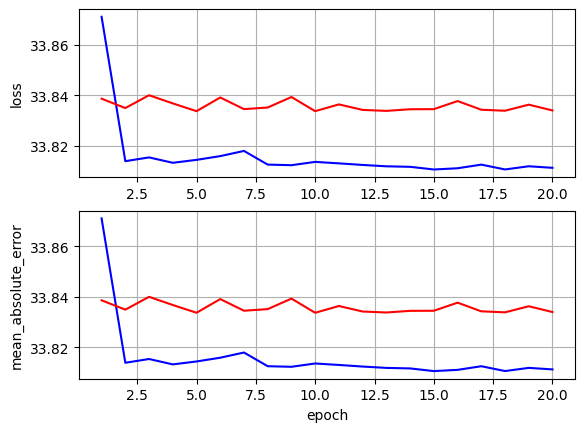

In [ ]:
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), history.history['loss'], 'b',
         range(1,epochs+1), history.history['val_loss'],'r')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), history.history['mean_absolute_error'], 'b',
         range(1,epochs+1), history.history['val_mean_absolute_error'],'r')
plt.ylabel('mean_absolute_error'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [ ]:
# printing the loss and MAE of the model on trainig data
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train MAE:', score[1])

Train loss: 33.81504440307617
Train accuracy: 33.81504440307617


## loading best model

In [ ]:
# loading the best model
model = load_model('model_HW1_6_b_2w_2.h5')
# viewing the summary
model.summary()
# printing the loss and MAE of the model on trainig data
score = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', score[0])
print('Train MAE:', score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2, 128)            640       
                                                                 
 dropout (Dropout)           (None, 2, 128)            0         
                                                                 
 dense_1 (Dense)             (None, 2, 128)            16512     
                                                                 
 dropout_1 (Dropout)         (None, 2, 128)            0         
                                                                 
 dense_2 (Dense)             (None, 2, 1)              129       
                                                                 
Total params: 17281 (67.50 KB)
Trainable params: 17281 (67.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
41406/41406 [=======

https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f https://keras.io/api/keras_tuner/hyperparameters/#float-method https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203 https://keras.io/api/keras_tuner/tuners/random/ https://stackoverflow.com/questions/68938984/using-random-search-in-keras-tuner